### Описание данных  

Файл содержит [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку
midprice - цена актива  
signal - сигнал, полученный от модели, которая оценивает изменение цены 

#### Цена актива
На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = \frac{(askbest(t) + bidbest(t))}{2} $$  

С помощью сигнала от модели определим прогноз цены в будущем:  
$$midprice(t + 1) = midprice(t) + signal(t)$$

### Задачa
Написать свою торговую стратегию, которая будет опираться на сигнал модели для принятия решения.  
#### Ограничения: 
- Максимальная позиция не должна превышать 1
- Нельзя самостоятельно вносить изменения в бэктест
- Стратегия должна содержать текстовое описание  

#### Критерии оценки стратегии:
- Pnl после комиссии 
- Количество сделок > 50

### Считывание данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from scipy import signal as sig
from scipy.signal import hilbert
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import plotly.express as px

from backtest import *

In [2]:
backtest_df = pd.read_parquet('data.parquet')

In [3]:
backtest_df.head()

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
index,,,,,,,
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320007,0.015,-0.004417
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320007,0.015,-0.004417
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325012,0.025,-0.004417
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325012,0.030,-0.004417
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.334991,0.020,-0.004417


### `signal` EDA

Предпросмотр данных

In [4]:
backtest_df.signal.describe()

count    7.361603e+06
mean    -8.139971e-05
std      9.671440e-03
min     -1.997090e-01
25%     -3.797737e-03
50%     -1.355679e-04
75%      3.510824e-03
max      2.317369e-01
Name: signal, dtype: float64

Гистограмма распределения

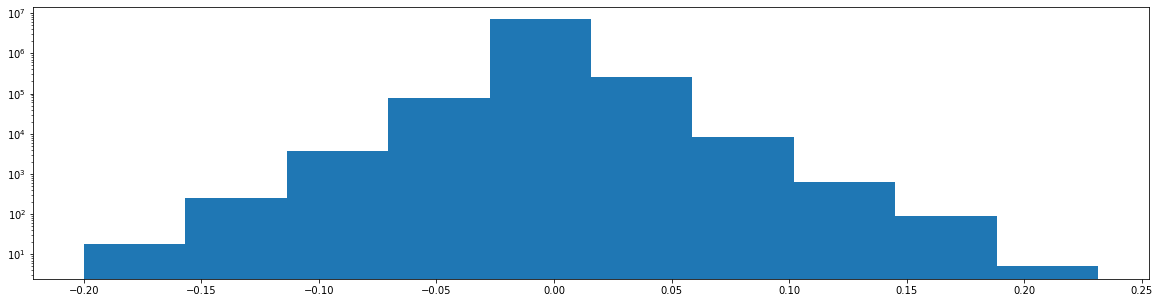

In [5]:
plt.figure(figsize=(20, 5))
plt.rc('axes', axisbelow=True)

plt.xticks(np.arange(min(backtest_df.signal), max(backtest_df.signal)+1, 0.05))
plt.hist(backtest_df.signal, log=True)

plt.show()

Попробуем поисследовать характеристики этого временного ряда. <br/>
    Но для начала, имеет смысл убрать наблюдения, где прирост `midprice` <= комиссии биржи, такие сигналы не смысла учитывать

In [6]:
print('Shape before ', backtest_df.shape[0])

backtest_df['price_diff'] = backtest_df['midprice'].diff()
backtest_df = backtest_df[abs(backtest_df['price_diff'] <= 0.0001)]

print('Shape after ', backtest_df.shape[0])

Shape before  7361603
Shape after  6414313


На первый взгляд в данных нет тренда, но всё же попробуем его убрать

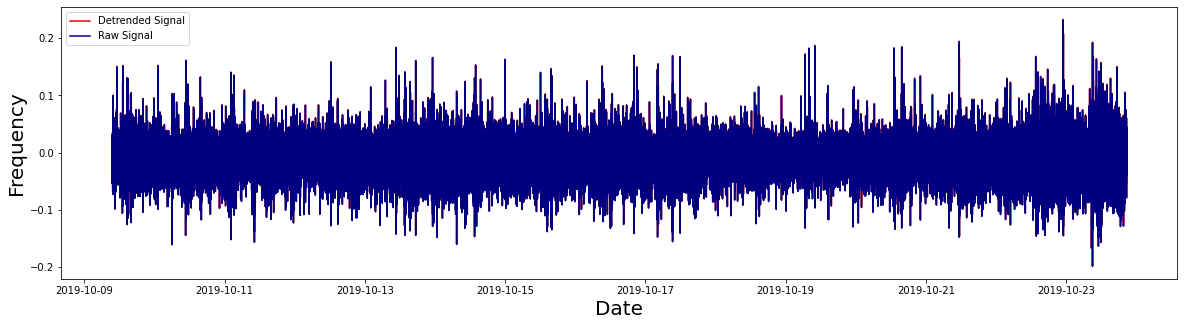

In [7]:
plt.figure(figsize=(20,5))

signal_detrend = sig.detrend(backtest_df.signal)

plt.plot(backtest_df.index, signal_detrend, color='red', label='Detrended Signal')
plt.plot(backtest_df.index, backtest_df.signal, color='navy', label='Raw Signal')

plt.legend(loc = 'upper left')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.show()

Тренда не оказалось, поробуем теперь избавиться от шума в `signal` при помощи трансформации Фурье

In [8]:
# denoising function
def fft_denoiser(x, n_components, to_real=True):

    n = len(x)
    fft = np.fft.fft(x, n)
    PSD = fft * np.conj(fft) / n
    _mask = PSD > n_components
    fft = _mask * fft
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

Создадим два отфильтрованных от шума `signal`, с разным кол-вом компонент

In [9]:
backtest_df['denoised_0001'] = fft_denoiser(x = np.array(backtest_df.signal),
                               n_components = 0.0001)

backtest_df['denoised_0005'] = fft_denoiser(x = np.array(backtest_df.signal),
                               n_components = 0.0005)

Построим три ряда

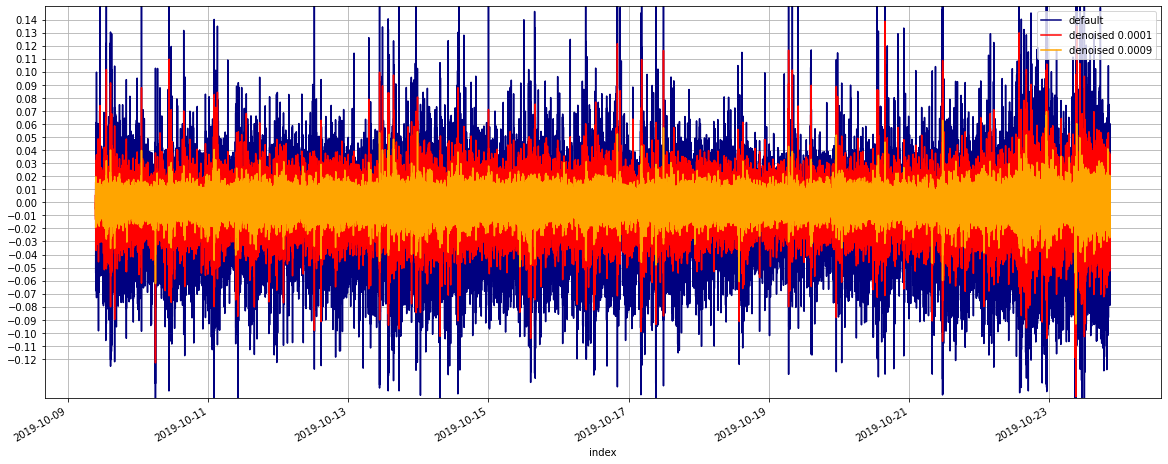

In [21]:
plt.figure(figsize=(20, 8))

ax1 = backtest_df.signal.plot(color='navy', grid=True, label='default')
ax2 = backtest_df.denoised_0001.plot(color='red', grid=True, label='denoised 0.0001')
ax3 = backtest_df.denoised_0005.plot(color='orange', grid=True, label='denoised 0.0009')

h1, l1 = ax1.get_legend_handles_labels()

plt.ylim(-0.15, 0.15)
plt.yticks(np.arange(-0.12, 0.15, 0.01))

plt.legend(h1, l1, loc='upper right')

plt.show();

Оставим только отфильтрованный `signal` с параметром `0.0001 ` и приблизим график

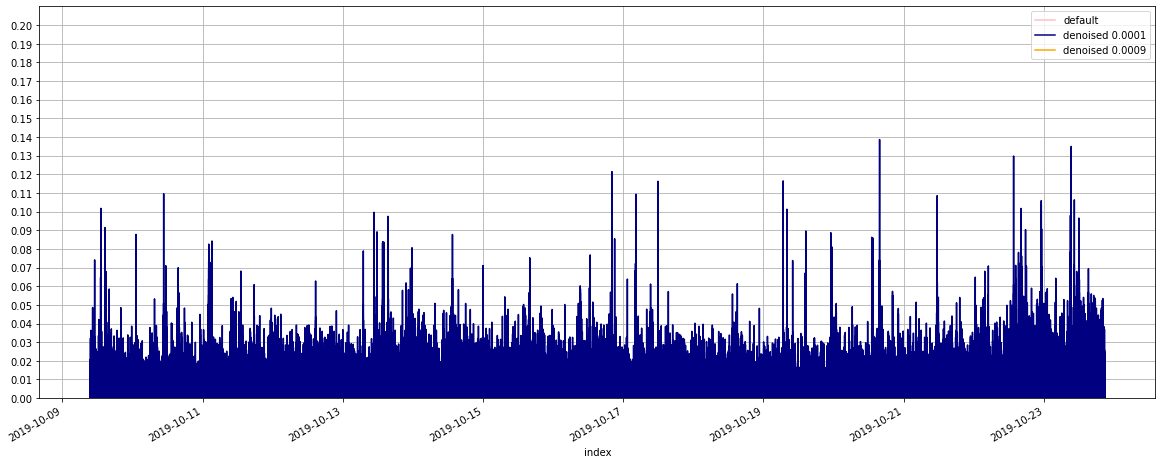

In [11]:
plt.figure(figsize=(20, 8))

#ax1 = backtest_df.signal.plot(color='red', grid=True, label='default')
ax2 = backtest_df.denoised_0001.plot(color='navy', grid=True, label='denoised 0.01')
#ax3 = backtest_df.denoised_005.plot(color='orange', grid=True, label='denoised 0.09')

plt.ylim(0, 0.21)
plt.yticks(np.arange(0, 0.21, 0.01))

plt.legend(h1, l1, loc='upper right')

plt.show();

Теперь визуально можно определить приблизительный диапазон операций для `signal`

Также посмотрим автокорреляцию и частичную автокорреляцию

/usr/local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


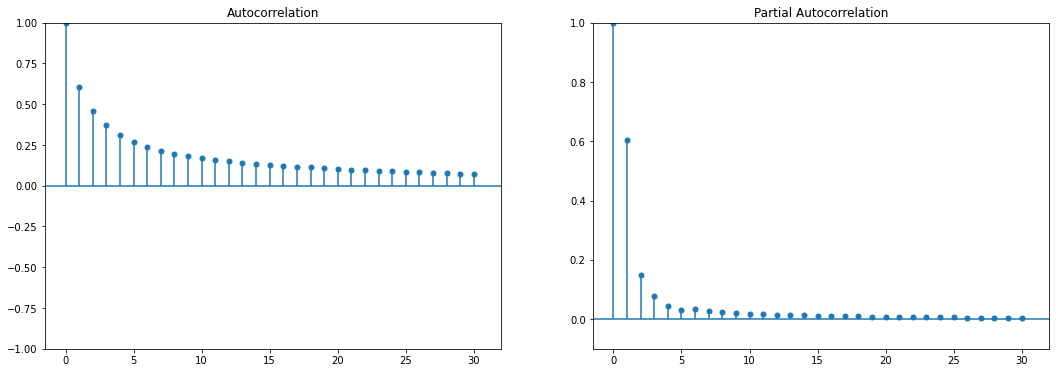

In [54]:
# too long to plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_acf(backtest_df.signal, ax=axes[0], lags=30)
plot_pacf(backtest_df.signal, ax=axes[1], lags=30)
axes[0].set_ylim([-0.1, 1])
axes[1].set_ylim([-0.1, 1])

plt.show();

Дополнительно исследуем Estimated Moving Average для `signal`

In [12]:
# smoothing factor - 0.1
backtest_df['EMA_0.1'] = backtest_df.signal.ewm(alpha=0.1, adjust=False).mean()

# smoothing factor - 0.3
backtest_df['EMA_0.3'] = backtest_df.signal.ewm(alpha=0.3, adjust=False).mean()

<Figure size 1080x720 with 0 Axes>

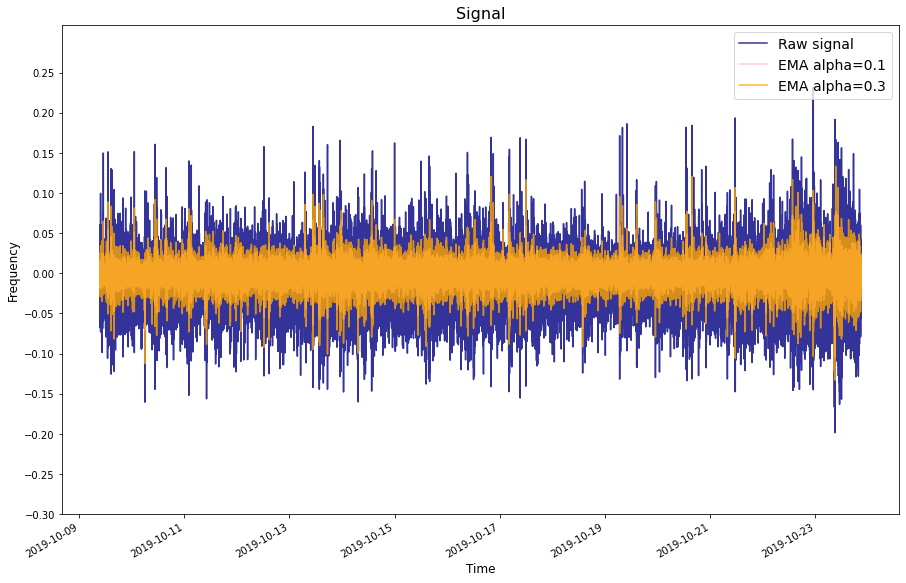

In [13]:
plt.figure(figsize=(15, 10))

colors = ['navy', 'pink', 'orange']

backtest_df[['signal', 'EMA_0.1', 'EMA_0.3']].plot(color=colors, alpha=0.8, figsize=(15, 10))

plt.legend(labels=['Raw signal', 'EMA alpha=0.1', 'EMA alpha=0.3'], fontsize=14, loc = 'upper right')

plt.ylim(0, 0.31)
plt.yticks(np.arange(-0.30, 0.30, 0.05))

plt.title('Signal', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show();

А теперь попробуем оценить статистику разностей `ask_amount` и `bid_amount`

In [14]:
array1 = np.array(backtest_df['ask_amount'])
array2 = np.array(backtest_df['bid_amount'])

backtest_df['am_diff'] = [[ii - jj for ii, jj in zip(i, j)] for i, j in zip(array1, array2)]

In [ ]:
# для всех значений очень долго
print('Mean list: ', np.mean(backtest_df['am_diff'][0], axis=0))

In [59]:
np.mean([item[0] for item in backtest_df['am_diff']])

-3.974539386138468

---

Исходя из первичного анализа данных, можно предложить **следующую стратегию**: <br/>

Так как базовая стратегия чувствительна к `signal`, то имеет смысл ввести ограничения на эту переменную, чтобы игнорировать сигналы на несущественные изменения цен.  <br/>
Предварительно отфильтровав шум и изменения цен, $\leq 0.00001$ комиссии биржи. Возьмем два пороговых значения:

- `signal` $\geq 0.1$ — для покупки
- `signal` $\leq -0.12$ — для продажи

Также введем ограничение на разницу объёма заявок:

- `amount_diff` $\leq -4$ — для покупки
- `amount_diff` $\geq 4$ — для продажи

Тогда, стратегия будет выглядеть так:

In [76]:
def custom_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершаем покупку если: signal >= 0.09, amount_diff <= -6 и текущая абсолютная позиция меньше максимальной.
    Совершаем продажу если: signal =< 0.15, amount_diff >= 6 и текущая абсолютная позиция меньше максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    amount_diff = ask_amount[0] - bid_amount[0]

    order_size = 0

    if ((signal > 0.1) & (amount_diff < -4)): # покупка
        
        if current_position < 0:
            order_size = -current_position
            
        order_size += min(trade_size, max_position - current_position)  # определение объема сделки


    elif ((signal < -0.12) & (amount_diff > 4)):  # продажа
        
        if current_position > 0:
            order_size = -current_position
            
        order_size += -min(trade_size, max_position + current_position)  # определение объема сделки

    
    return order_size

In [77]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}

{'pnl': 91.61803219999997, 'pnl_after_fee': 85.27015190328001, 'actions': 99}


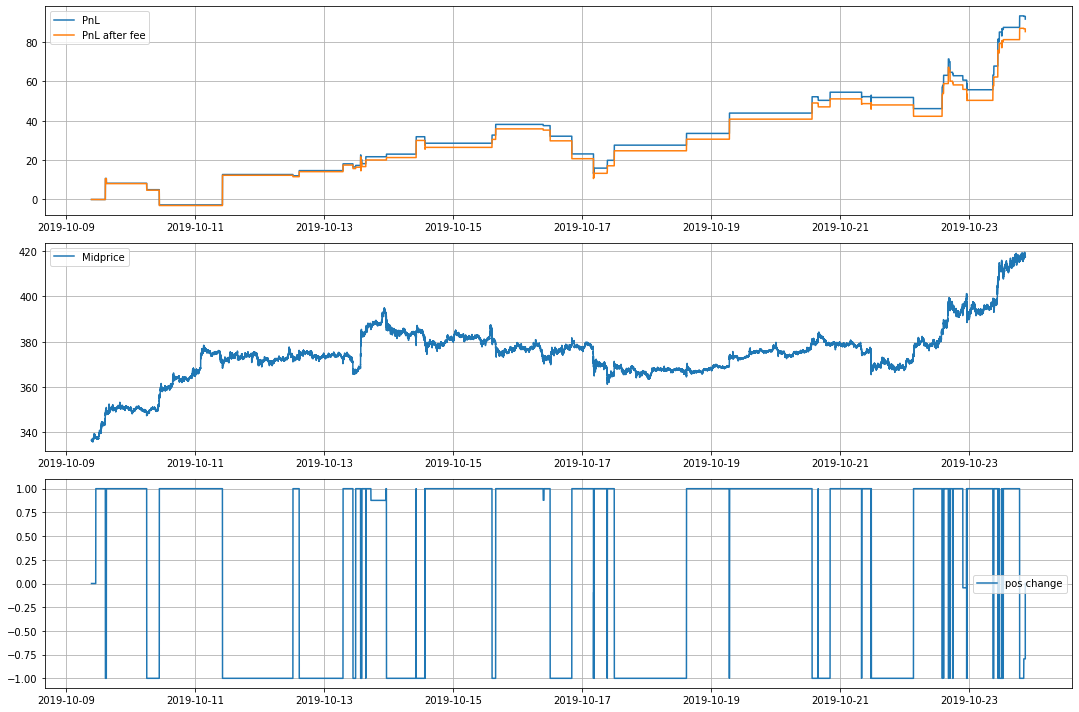

CPU times: user 1min 31s, sys: 10.1 s, total: 1min 41s
Wall time: 1min 41s


<Figure size 432x288 with 0 Axes>

In [78]:
%%time

summary, result = backtest(backtest_df, custom_strategy, strategy_params, viz=True)

In [79]:
summary

{'pnl': 91.61803219999997, 'pnl_after_fee': 85.27015190328001, 'actions': 99}

In [82]:
result.head()

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal,price_diff,denoised_0001,denoised_0005,EMA_0.1,EMA_0.3,am_diff,pnl,pnl_after_fee,decisions,pos
index,,,,,,,,,,,,,,,,,
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320007,0.015,-0.004417,0.0,-0.001045,-0.002087,-0.004417,-0.004417,"[-8.10688, -97.41963999999999, 7.4327299999999...",0.0,0.0,hold,0.0
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325012,0.030,-0.004417,0.0,-0.004196,-0.003472,-0.004417,-0.004417,"[-2.8686599999999998, 16.457, -100.48281, -18....",0.0,0.0,hold,0.0
2019-10-09 09:30:03.865,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.2]","[8.98892, 8.67933, 9.11755, 125.39419, 205.41559]",336.334991,0.020,-0.004417,0.0,-0.007115,-0.004441,-0.004417,-0.004417,"[-5.578250000000001, 19.29522, 15.793830000000...",0.0,0.0,hold,0.0
2019-10-09 09:30:04.165,"[336.36, 336.42, 336.43, 336.46, 336.47]","[115.07084, 3.41067, 28.38785, 81.54665, 24.91...","[336.35, 336.32, 336.3, 336.27, 336.25]","[9.20053, 0.28291, 7.93256, 0.2, 6.08892]",336.355011,0.000,-0.004417,0.0,-0.002823,-0.004659,-0.004417,-0.004417,"[105.87031, 3.1277600000000003, 20.45529, 81.3...",0.0,0.0,hold,0.0
2019-10-09 09:30:04.265,"[336.36, 336.37, 336.42, 336.43, 336.46]","[115.07084, 3.08427, 3.41067, 28.38785, 78.999]","[336.35, 336.32, 336.3, 336.27, 336.25]","[0.00053, 0.28291, 2.26133, 0.2, 6.08892]",336.355011,0.000,-0.004417,0.0,-0.003333,-0.004000,-0.004417,-0.004417,"[115.07031, 2.80136, 1.14934, 28.18785, 72.91008]",0.0,0.0,hold,0.0


In [81]:
result.decisions.value_counts()

hold    6414214
buy          51
sell         48
Name: decisions, dtype: int64

Стратегия получилась хоть и с положительным `pnl_after_fee`, но очень аккуратная в действиях. <br/>

Возможно, в дальнейшем, стоит использовать веса для значимых сигналов и учитывать их в стратегии.